# Теоремы об исключении и продолжении

## Упражнения к параграфу 1

### Упражнение 2

Рассмотрим систему уравнений $$x^2 + 2y^2 = 3$$
                         $$x^2 + xy + y^2 = 3$$
(a) Пусть $I = (x^2 + 2y^2 - 3, x^2 + xy + y^2 - 3)$ - соответствующий идеал.
Найти базисы идеалов $I\cap k[x]$ и $I\cap k[y]$.

(b) Найти все решения системы.

(c) Определить, какие из этих решений рациональны.

(d) Найти наименьшее поле $k$ такое, что все решения принадлежат $k^2$.

**Решение.**

По **теореме об исключении** базис $G_1$ идеала $I_1 = I\cap k[x]$ равен $G \cap k[x]$, где $G$ - базис Грёбнера идеала $I$.

Тогда для начала найдём базис Грёбнера $G$ относительно лексикографического порядка $y > x$. Для этого нам понадобится функция $groebner$ из библиотеки $SymPy$.

In [40]:
from sympy.polys.polytools import groebner
from sympy.abc import x, y

F = [y**2 + x*y + x**2 - 3, 2*y**2 + x**2 - 3]           # Идеал I
G = groebner(F, y, x, order='lex')                       # Базис Грёбнера g

print('\nБазис Грёбнера относительно y > x:')

def print_groebner(G):
    if (len(G) > 0):
        for i in range(len(G.exprs)):
            print(' g', i+1, ' = ', G.exprs[i], sep='')   # метод .exprs позволяет записать полином в виде красивого выражения
    else:
        print('is empty!')

print_groebner(G)



Базис Грёбнера относительно y > x:
 g1 = x**3 - 3*x + 2*y
 g2 = x**4 - 4*x**2 + 3


Теперь несложно найти $G_1 = G \cap k[x]$:

In [41]:
from sympy import Poly, LC
from sympy import solve, solve_poly_system

poly_system = G.exprs

def first_exclusion_step(var, poly_system, *args):
    G_ex = []
    I_next = []
    index = 1
    for pol in poly_system:
        f = Poly(pol, *var)                                  # Представим каждое выражение как полином от переменной X
        if f.free_symbols_in_domain.isdisjoint(set(args)):   # Если помимо переменной X в полиноме НЕТ свободной переменной Y,
            G_ex.append((f.as_expr(), index))                # то этот полином содержится в G1
        else:
            I_next.append((Poly(f, args), index))            # Запомним отдельно полиномы, которые не содержатся в G1.
        index += 1
    return G_ex, I_next

G1, I0 = first_exclusion_step([x], poly_system, y)

print('\nБазис Грёбнера 1-ого исключающего идеала:')

def print_groebner_of_ex(G):
    if (len(G) > 0):
        for pol in G:
            print(' g', pol[1], ' = ', pol[0], sep='')
    else:
        print('is empty!')

print_groebner_of_ex(G1)



Базис Грёбнера 1-ого исключающего идеала:
 g2 = x**4 - 4*x**2 + 3


Аналогично найдём $G1 = G \cap k[y]$. Для этого нам нужен лексикографический порядок $x > y$.

In [42]:
F = [x**2 + 2*y**2 - 3, x**2 + x*y + y**2 - 3]           # Идеал I
G = groebner(F, x, y, order='lex')                       # Базис Грёбнера G

print('\nБазис Грёбнера относительно x > y:')
print_groebner(G)

poly_system = G.exprs
G1, I0 = first_exclusion_step([y], poly_system, x)

print('\nБазис Грёбнера 1-ого исключающего идеала:')     
print_groebner_of_ex(G1)



Базис Грёбнера относительно x > y:
 g1 = x**2 + 2*y**2 - 3
 g2 = x*y - y**2
 g3 = y**3 - y

Базис Грёбнера 1-ого исключающего идеала:
 g3 = y**3 - y


Заметим, что многочлен $g_3$ зависит только от одной переменной $y$. Мы сделали **шаг исключения**, избавившись от переменной $x$. Решив это уравнение, получим возможные значения $y$ для решения всей системы - это будет **частичным решением**.

По **теореме о продолжении** следующий шаг - шаг продолжения - может не выполниться (т.е. частичное решение не верно для всей системы), если коэффициенты при старших мономах одновременно равны нулю. Сделаем проверку на это для остальных полиномов, не содержащихся в $G_1$

In [43]:
roots_y = []
poly_system = []
for pol in G1:
    f_y = Poly(pol[0], y)
    poly_system.append(f_y)
roots_y = solve_poly_system(poly_system, y)               # Нашли частичные решения функцией solve_poly_system()
print('корни Y:', roots_y)
    
for root_y in roots_y:
    for pol in I0:
        f_x = Poly(pol[0], x)
        if root_y not in solve(LC(f_x), y):               # Проверка, обращает ли в ноль частичное решение старшие мономы
            break                                         # полиномов из I0
    else:
        roots_y.remove(root_y)
print('корни Y после проверки:', roots_y)


корни Y: [(-1,), (0,), (1,)]
корни Y после проверки: [(-1,), (0,), (1,)]


Теперь сделаем **шаг продолжения**. Найдём все решения системы и сразу определим, какие из решений рациональны.

In [44]:
# Найдём значения X:
roots_x = []
for root_y in roots_y:
    poly_system = []                                           # Для каждого частичного решения Y будут свои решения X
    for pol in I0:
        poly_system.append(pol[0].subs(y, root_y[0]))          # Подставим значения частичных решений методом .subs(y,root)
    solution = solve_poly_system(poly_system, x)               # и решим систему уравнений от одной переменной X
    roots_x.append(solution)

# Теперь мы знаем все решения системы, "закинем" их красиво в список решений solutions:
solutions = []
for i in range(len(roots_y)):
    for root_x in roots_x[i]:
        solutions.append((root_x[0], roots_y[i][0]))
print('Все решения системы: ')
print(*solutions, sep='\n')


# Определим, какие решения рациональны
def rationals(solutions):
    rationals = []
    for solution in solutions:
        if all(sol.is_rational for sol in solution):
            rationals.append(solution)
    return rationals

print('\nРациональные решения системы:')
print(rationals(solutions))

# И найдём наименьшее поле k
from sympy import QQ, RR

def min_field(solutions):
    extension = []
    field = QQ
    for solution in solutions:
        if field == QQ:
            if not all(sol.is_rational for sol in solution):
                if not all(sol.is_real for sol in solution):
                    field = RR
                    extension = []
                    for sol in solution:
                        if not sol.is_real:
                            extension.append((abs(sol).primitive())[1])
                else:
                    for sol in solution:
                        if not sol.is_rational:
                            extension.append((abs(sol).primitive())[1])
        else:
            if not all(sol.is_real for sol in solution):
                for sol in solution:
                    if not sol.is_real:
                        extension.append((abs(sol).primitive())[1])
    return ('{0}('.format(field) + str(set(extension)) + ')').replace('{', '').replace('}', '')

print('Наименьшее поле k такое, что все решения принадлежат k^2, - это', min_field(solutions))


Все решения системы: 
(-1, -1)
(-sqrt(3), 0)
(sqrt(3), 0)
(1, 1)

Рациональные решения системы:
[(-1, -1), (1, 1)]
Наименьшее поле k такое, что все решения принадлежат k^2, - это QQ(sqrt(3))


### Упражнение 4 ###

Рассмотрим теперь систему из трёх уравнений от трёх переменных: $x, y, z$.
$$x^2 + y^2 + z^2 = 4$$
$$x^2 + 2y^2 = 5$$
$$xz = 1$$
Нужно найти базисы исключающих идеалов $I_1, I_2$ идеала $I = (x^2 + y^2 + z^2 - 4, x^2 + 2y^2 - 5, xz - 1)$ и выяснить, сколько рациональных решений имеет эта система.

**Решение**
По теореме об исключении базис исключающего идеала $I_1$ равен $G_1 = G \cap k[y, z]$, а базис исключающего идеала $I_2$ соответственно равен $G_2 = G \cap k[z]$.
Далее решение будет аналогичным (добавится лишь ещё один шаг исключения и ещё один шаг продолжения).

In [45]:
from sympy.abc import z

F = [x**2 + y**2 + z**2 - 4, x**2 + 2*y**2 - 5, x*z - 1]
G = groebner(F, x, y, z, order='lex')

print('\nБазис Грёбнера относительно x > y > z:')
print_groebner(G)



Базис Грёбнера относительно x > y > z:
 g1 = x + 2*z**3 - 3*z
 g2 = y**2 - z**2 - 1
 g3 = 2*z**4 - 3*z**2 + 1


Теперь найдём $G_1$:

In [46]:
poly_system = G.exprs
G2, I1 = first_exclusion_step([z], poly_system, x, y)

print('\nБазис Грёбнера 2-ого исключающего идеала:')
print_groebner_of_ex(G2)



Базис Грёбнера 2-ого исключающего идеала:
 g3 = 2*z**4 - 3*z**2 + 1


Найдём частные решения $z$:

In [47]:
roots_z = []
poly_system = []
for pol in G2:
    f_z = Poly(pol[0], z)
    poly_system.append(f_z)
roots_z = solve_poly_system(poly_system, z)
print('корни Z:', roots_z)

for root_z in roots_z:
    for pol in I1:
        f_xy = Poly(pol[0], x, y)
        if root_z not in solve(LC(f_xy), z):
            break
    else:
        roots_z.remove(root_z)
print('корни Z после проверки:', roots_z)


корни Z: [(-1,), (1,), (-sqrt(2)/2,), (sqrt(2)/2,)]
корни Z после проверки: [(-1,), (1,), (-sqrt(2)/2,), (sqrt(2)/2,)]


Найдём $G_1$

In [48]:
poly_system = []
for pol in I1:
    poly_system.append(pol[0].subs(z, roots_z[0][0]))

def exclusion_step(var, poly_system, I_prev, *args):
    G_ex = []
    I_next = []
    index = 1
    for pol in poly_system:
        f = Poly(pol, *var)
        if (f != 0):
            if f.free_symbols_in_domain.isdisjoint(set(args)):
                G_ex.append((I_prev[index - 1][0].as_expr(), index))
            else:
                I_next.append((I_prev[index - 1][0], index))
        index += 1
    return G_ex, I_next

G1, I0 = exclusion_step([y], poly_system, I1, x)

print('\nБазис Грёбнера 1-ого исключающего идеала:')
print_groebner_of_ex(G1)



Базис Грёбнера 1-ого исключающего идеала:
 g2 = y**2 - z**2 - 1


Подставим известные частные решения $z$ и получим уравнение от одной переменной $y$:

In [49]:
roots_y = []
for root_z in roots_z:
    poly_system = []
    for pol in G1:
        f_y = Poly(pol[0].as_expr().subs(z, root_z[0]), y)
        poly_system.append(f_y)
    solution = solve_poly_system(poly_system, y)
    roots_y.append(solution)
print('корни Y:', roots_y)

for i in range(len(roots_z)):
    for root_y in roots_y[i]:
        for pol in I0:
            f_x = Poly(pol[0].as_expr().subs({y:root_y, z:roots_z[i][0]}), x)
            if ((root_y, roots_z[i][0])) not in solve(LC(f_x), y, z):
                break
        else:
            roots_y.remove(root)
print('\nкорни Y после проверки:', roots_y, '\n')


корни Y: [[(-sqrt(2),), (sqrt(2),)], [(-sqrt(2),), (sqrt(2),)], [(-sqrt(6)/2,), (sqrt(6)/2,)], [(-sqrt(6)/2,), (sqrt(6)/2,)]]

корни Y после проверки: [[(-sqrt(2),), (sqrt(2),)], [(-sqrt(2),), (sqrt(2),)], [(-sqrt(6)/2,), (sqrt(6)/2,)], [(-sqrt(6)/2,), (sqrt(6)/2,)]] 



У нас есть 4 частных решения $z$ и для каждого мы получили по два частных решения $y$.
Теперь, зная $z$ и $y$, мы можем найти $x$, а значит, все решения системы.

In [50]:
# Найдём значения X:
roots_x = []
for i in range(len(roots_z)):
    for root_y in roots_y[i]:
        poly_system = []
        for pol in I0:
            poly_system.append(Poly(pol[0].as_expr().subs({y:root_y, z:roots_z[i][0]}), x))
        solution = solve_poly_system(poly_system, x)
        roots_x.append(solution)

# Теперь мы знаем все решения системы, "закинем" их красиво в список решений solutions:
solutions = []
index = 0
for i in range(len(roots_z)):
    for j in range(len(roots_y[i])):
        solutions.append((roots_x[index][0][0], roots_y[i][j][0], roots_z[i][0]))
        index += 1
print('Все решения системы: ')
print(*solutions, sep='\n')

# Определим, какие решения рациональны

print('\nРациональные решения системы:')
print(rationals(solutions))

print('Наименьшее поле k такое, что все решения принадлежат k^2, - это', min_field(solutions))


Все решения системы: 
(-1, -sqrt(2), -1)
(-1, sqrt(2), -1)
(1, -sqrt(2), 1)
(1, sqrt(2), 1)
(-sqrt(2), -sqrt(6)/2, -sqrt(2)/2)
(-sqrt(2), sqrt(6)/2, -sqrt(2)/2)
(sqrt(2), -sqrt(6)/2, sqrt(2)/2)
(sqrt(2), sqrt(6)/2, sqrt(2)/2)

Рациональные решения системы:
[]
Наименьшее поле k такое, что все решения принадлежат k^2, - это QQ(sqrt(2), sqrt(6))


Таким образом, ни одно из решений системы не является рациональным.

### Упражнение 7 ###

Рассмотрим систему
$$t^2 + x^2 + y^2 + z^2 = 0$$
$$t^2 + 2x^2 - xy - z^2 = 0$$
$$t + y^3 - z^3 = 0$$
Мы хотим исключить $t$.

$I = (t^2 + x^2 + y^2 + z^2, t^2 + 2x^2 - xy - z^2, t + y^3 - z^3)$ - соответствующий идеал.

(a) Используя lex-упорядочение с $t > x > y > z$, найти базис Грёбнера $G$ для $I$, а затем базис $G_1$ для $I \cap k[x, y, z]$.

(b) Используя grevlex-упорядочение, найти базис Грёбнера идеала $I \cap k[x, y, z]$.

(c) Объединить полученный в п.(b) базис с полиномом $t + y^3 - z^3$ и доказать, что это объединение является базисом Грёбнера для идеала $I$ по отношению к упорядочению $>_l$.

**Решение**

Найдём базис Грёбнера $G$ и $G_3$ относительно $lex-$упорядочения с $t > x > y > z$:


In [51]:
from sympy.abc import t

F_lex = [t**2 + x**2 + y**2 + z**2, t**2 + 2*x**2 - x*y - z**2, t + y**3 - z**3]
G_lex = groebner(F_lex, t, x, y, z, order='lex')

print('\nБазис Грёбнера относительно lex-упорядочения с t > x > y > z:')
print_groebner(G_lex)


poly_system = G_lex.exprs
G1_lex, I0_lex = first_exclusion_step([x, y, z], poly_system, t)
    
print('\nБазис Грёбнера 1-ого исключающего идеала:')
print_groebner_of_ex(G1_lex)
print('\n')



Базис Грёбнера относительно lex-упорядочения с t > x > y > z:
 g1 = t + y**3 - z**3
 g2 = x**2 + y**6 - 2*y**3*z**3 + y**2 + z**6 + z**2
 g3 = x*y + y**6 - 2*y**3*z**3 + 2*y**2 + z**6 + 3*z**2
 g4 = x*z**6 + 3*x*z**2 - y**11 + 4*y**8*z**3 - 5*y**7 - 5*y**5*z**6 - 3*y**5*z**2 + 10*y**4*z**3 - 5*y**3 + 2*y**2*z**9 + 6*y**2*z**5 - 3*y*z**6 - 7*y*z**2
 g5 = y**12 - 4*y**9*z**3 + 5*y**8 + 6*y**6*z**6 + 6*y**6*z**2 - 10*y**5*z**3 + 5*y**4 - 4*y**3*z**9 - 12*y**3*z**5 + 5*y**2*z**6 + 13*y**2*z**2 + z**12 + 6*z**8 + 9*z**4

Базис Грёбнера 1-ого исключающего идеала:
 g2 = x**2 + y**6 - 2*y**3*z**3 + y**2 + z**6 + z**2
 g3 = x*y + y**6 - 2*y**3*z**3 + 2*y**2 + z**6 + 3*z**2
 g4 = x*z**6 + 3*x*z**2 - y**11 + 4*y**8*z**3 - 5*y**7 - 5*y**5*z**6 - 3*y**5*z**2 + 10*y**4*z**3 - 5*y**3 + 2*y**2*z**9 + 6*y**2*z**5 - 3*y*z**6 - 7*y*z**2
 g5 = y**12 - 4*y**9*z**3 + 5*y**8 + 6*y**6*z**6 + 6*y**6*z**2 - 10*y**5*z**3 + 5*y**4 - 4*y**3*z**9 - 12*y**3*z**5 + 5*y**2*z**6 + 13*y**2*z**2 + z**12 + 6*z**8 + 9*z**

Мы получили четыре полинома, один из которых имеет степень 12.

Теперь найдём базис Грёбнера, используя $grevlex-$упорядочение:


In [52]:
def polys_to_list(G):
    G_new = []
    for pol in G:
        G_new.append(pol[0])
    return G_new
G1 = polys_to_list(G1_lex)

G1_grevlex = groebner(G1, t, x, y, z, order='grevlex')

print('\nБазис Грёбнера 1-ого исключающего идеала относительно grevlex-упорядочения:')
print_groebner(G1_grevlex)



Базис Грёбнера 1-ого исключающего идеала относительно grevlex-упорядочения:
 g1 = x*y + y**6 - 2*y**3*z**3 + 2*y**2 + z**6 + 3*z**2
 g2 = x**2 - x*y - y**2 - 2*z**2


Добавим полином $t + y^3 - z^3$:

In [53]:
from sympy.polys.polytools import parallel_poly_from_expr

G = G1_grevlex.exprs
G.append(t + y**3 - z**3)
G = parallel_poly_from_expr(G)

def print_groebner(G):
    print('Базис Грёбнера:')
    if (len(G) > 0):
        try:
            for i in range(len(G.exprs)):
                print(' g', i+1, ' = ', G.exprs[i], sep='')
        except AttributeError:
            for i in range(len(G)):
                print(' g', i+1, ' = ', G[i].as_expr(), sep='')
    else:
        print('is empty!')

print_groebner(G[0])


Базис Грёбнера:
 g1 = x*y + y**6 - 2*y**3*z**3 + 2*y**2 + z**6 + 3*z**2
 g2 = x**2 - x*y - y**2 - 2*z**2
 g3 = t + y**3 - z**3


**Мы получили базис Грёбнера для $I$ по отношению к упорядочению 1-исключающего типа.**
Этот базис намного проще найденного ранее, состоящего из 4-ёхэлементов, базиса.

# Другие применения базисов Грёбнера

## Упражнения к параграфу 8 главы 2

### Упражнение 1

Определить, принадлежит ли полином $f = xy^3 - z^2 + y^5 - z^3$ идеалу $I = (-x^3 + y, x^2y - z)$.

In [54]:
I = [-(x**3) + y, (x**2)*y - z]
f = x*(y**3) - z**2 + y**5 - z**3

print('I = ', I)
print('f = ', f, '\n')


def in_ideal(f, I):
    G = groebner(I, x, y, z, order='lex')
    print_groebner(G)
    if G.contains(f):                                   # метод contains() проверяет, принадлежит ли полином идеалу
        print('\nf принадлежит идеалу I \n')
    else:
        print('\nf не принадлежит идеалу I \n')
        
in_ideal(f, I)


I =  [-x**3 + y, x**2*y - z]
f =  x*y**3 + y**5 - z**3 - z**2 

Базис Грёбнера:
 g1 = x**3 - y
 g2 = x**2*y - z
 g3 = x*y**3 - z**2
 g4 = x*z - y**2
 g5 = y**5 - z**3

f принадлежит идеалу I 



### Упражнение 2

Определить, принадлежит ли полином $f = x^3z - 2y^2$ идеалу $I = (xz - y, xy + 2z^2, y - z)$.

In [55]:
I = [x*z - y, x*y + 2*(z**2), y - z]
f = (x**3)*z - 2*(y**2)

print('I = ', I)
print('f = ', f, '\n')

in_ideal(f, I)


I =  [x*z - y, x*y + 2*z**2, y - z]
f =  x**3*z - 2*y**2 

Базис Грёбнера:
 g1 = x*z - z
 g2 = y - z
 g3 = 2*z**2 + z

f не принадлежит идеалу I 



### Упражнение 3

Найти точки в $\mathbf{C}^3$, принадлежащие многообразию $\mathbf{V}(x^2 + y^2 + z^2 - 1, x^2 + y^2 + z^2 - 2x, 2x - 3y - z)$

In [56]:
F = [x**2 + y**2 + z**2 - 1, x**2 + y**2 + z**2 - 2*x, 2*x - 3*y - z]
print('\n V', F, '\n', sep='')
G = groebner(F, x, y, z, order='lex')
print_groebner(G)



 V[x**2 + y**2 + z**2 - 1, x**2 - 2*x + y**2 + z**2, 2*x - 3*y - z]

Базис Грёбнера:
 g1 = 2*x - 1
 g2 = 3*y + z - 1
 g3 = 40*z**2 - 8*z - 23


А дальше привычный нам алгоритм исключения переменных:

In [57]:

poly_system = G.exprs
G2, I1 = first_exclusion_step([z], poly_system, x, y)

print('\nБазис Грёбнера 2-ого исключающего идеала:')
print_groebner_of_ex(G2)


roots_z = []
poly_system = []
for pol in G2:
    f_z = Poly(pol[0], z)
    poly_system.append(f_z)
roots_z = solve_poly_system(poly_system, z)
print('\nкорни Z:', roots_z)

for root_z in roots_z:
    for pol in I1:
        f_xy = Poly(pol[0], x, y)
        if root_z not in solve(LC(f_xy), z):
            break
    else:
        roots_z.remove(root_z)
print('корни Z после проверки:', roots_z)


poly_system = []
for pol in I1:
    poly_system.append(pol[0].subs(z, roots_z[0][0]))

G1, I0 = exclusion_step([y], poly_system, I1, x)

print('\nБазис Грёбнера 1-ого исключающего идеала:')
print_groebner_of_ex(G1)


roots_y = []
for root_z in roots_z:
    poly_system = []
    for pol in G1:
        f_y = Poly(pol[0].as_expr().subs(z, root_z[0]), y)
        poly_system.append(f_y)
    solution = solve_poly_system(poly_system, y)
    roots_y.append(solution)
print('\nкорни Y:', roots_y)

for i in range(len(roots_z)):
    for root_y in roots_y[i]:
        for pol in I0:
            f_x = Poly(pol[0].as_expr().subs({y:root_y, z:roots_z[i][0]}), x)
            if ((root_y, roots_z[i][0])) not in solve(LC(f_x), y, z):
                break
        else:
            roots_y[i].remove(root_y)
print('корни Y после проверки:', roots_y, '\n')


roots_x = []
for i in range(len(roots_z)):
    for root_y in roots_y[i]:
        poly_system = []
        for pol in I0:
            poly_system.append(Poly(pol[0].as_expr().subs({y:root_y, z:roots_z[i][0]}), x))
        solution = solve_poly_system(poly_system, x)
        roots_x.append(solution)
print('Корни X: ', roots_x)


solutions = []
index = 0
for i in range(len(roots_z)):
    for j in range(len(roots_y[i])):
        solutions.append((roots_x[index][0][0], roots_y[i][j][0], roots_z[i][0]))
        index += 1
print('\nВсе решения системы: ')
print(*solutions, sep='\n')



Базис Грёбнера 2-ого исключающего идеала:
 g3 = 40*z**2 - 8*z - 23

корни Z: [(1/10 + 3*sqrt(26)/20,), (-3*sqrt(26)/20 + 1/10,)]
корни Z после проверки: [(1/10 + 3*sqrt(26)/20,), (-3*sqrt(26)/20 + 1/10,)]

Базис Грёбнера 1-ого исключающего идеала:
 g2 = 3*y + z - 1

корни Y: [[(-sqrt(26)/20 + 3/10,)], [(sqrt(26)/20 + 3/10,)]]
корни Y после проверки: [[(-sqrt(26)/20 + 3/10,)], [(sqrt(26)/20 + 3/10,)]] 

Корни X:  [[(1/2,)], [(1/2,)]]

Все решения системы: 
(1/2, -sqrt(26)/20 + 3/10, 1/10 + 3*sqrt(26)/20)
(1/2, sqrt(26)/20 + 3/10, -3*sqrt(26)/20 + 1/10)


Таким образом, мы получили все две точки, принадлежащие многообразию $\mathbf{V}(x^2 + y^2 + z^2 - 1, x^2 + y^2 + z^2 - 2x, 2x - 3y - z)$

### Упражнение 5

Рассмотрим функцию $f(x, y) = (x^2 + y^2 - 4)(x^2 + y^2 - 1) + (x - 3/2)^2 + (y - 3/2)^2$

(a) Найти все особые точки функции $f(x, y)$.

(b) Определить, какие из них являются локальными максимумами, какие - минимумами, а какие - седлами.

**Решение**

Рассмотрим частные производные функции и приравняем их к нулю, чтобы найти особые точки. Заметим, что мы получили полиномиальную систему уравнений. Решим её с помощью базисов Грёбнера.

In [58]:
from sympy import diff

f = (x**2 + y**2 - 4)*(x**2 + y**2 - 1) + (x - 1.5)**2 + (y - 1.5)**2

f_x = diff(f, x)
f_y = diff(f, y)
I = [f_x, f_y]

print('\nf =', f)
print("I = (f'_x, f'_y")
print("\nf'_x =", f_x)
print("f'_x =", f_y, '\n')


G = groebner(I, x, y, order='lex')
print_groebner(G)

poly_system = G.exprs
G1, I0 = first_exclusion_step([y], poly_system, x)

print('\nБазис Грёбнера 1-ого исключающего идеала:')
print_groebner_of_ex(G1)


roots_y = []
poly_system = []
for pol in G1:
    f_y = Poly(pol[0], y)
    poly_system.append(f_y)
roots_y = solve_poly_system(poly_system, y)
print('\nкорни Y:', roots_y)

for root_y in roots_y:
    for pol in I0:
        f_x = Poly(pol[0], x)
        if root_y not in solve(LC(f_x), y):
            break
    else:
        roots_y.remove(root_y)
print('корни Y после проверки:', roots_y)

roots_x = []
for root_y in roots_y:
    poly_system = []
    for pol in I0:
        poly_system.append(pol[0].subs(y, root_y[0]))
    solution = solve_poly_system(poly_system, x)
    roots_x.append(solution)
print('\nкорни X:', roots_x, '\n')


solutions = []
for i in range(len(roots_y)):
    for root_x in roots_x[i]:
        solutions.append((root_x[0], roots_y[i][0]))
print('Все решения системы: ')
print(*solutions, sep='\n')




f = (x - 1.5)**2 + (y - 1.5)**2 + (x**2 + y**2 - 4)*(x**2 + y**2 - 1)
I = (f'_x, f'_y

f'_x = 2*x*(x**2 + y**2 - 4) + 2*x*(x**2 + y**2 - 1) + 2*x - 3.0
f'_x = 2*y*(x**2 + y**2 - 4) + 2*y*(x**2 + y**2 - 1) + 2*y - 3.0 

Базис Грёбнера:
 g1 = 1.0*x - 1.0*y
 g2 = 1.0*y**3 - 1.0*y - 0.375

Базис Грёбнера 1-ого исключающего идеала:
 g2 = 1.0*y**3 - 1.0*y - 0.375

корни Y: [(-0.651387818865997,), (-0.500000000000000,), (1.15138781886600,)]
корни Y после проверки: [(-0.651387818865997,), (-0.500000000000000,), (1.15138781886600,)]

корни X: [[(-0.651387818865997,)], [(-0.500000000000000,)], [(1.15138781886600,)]] 

Все решения системы: 
(-0.651387818865997, -0.651387818865997)
(-0.500000000000000, -0.500000000000000)
(1.15138781886600, 1.15138781886600)


Теперь определим, какие из особых точек являются локальными максимумами, какие - минимумами, а какие - седлами. Для этого подставим каждую особую точку $M_0$ в производные второго порядка. Для компактности будем использовать обозначения $A = f''_{xx}(M_0), B = f''_{xy}(M_0), C = f''_{yy}(M_0)$.

Если $AC - B^2 < 0$, то в точке $M_0$ нет экстремума, следовательно, точка седловая.

Если $AC - B^2 > 0$ и $A > 0$, то это локальный минимум, если же в этом случае $A < 0$, то точка - максимум.

In [59]:
f_xx = diff(f, x, x)
f_xy = diff(f, x, y)
f_yy = diff(f, y, y)
print('\nf"_xx =', f_xx, '\nf"_xy =', f_xy, '\nf"_yy =', f_yy)

for sol in solutions:
    f_xx_m = f_xx.subs({x:sol[0], y:sol[1]})
    f_xy_m = f_xy.subs({x:sol[0], y:sol[1]})
    f_yy_m = f_yy.subs({x:sol[0], y:sol[1]})
    if f_xx_m*f_yy_m - f_xy_m < 0:
        print('Точка', sol, '- седловая')
    elif f_xx_m*f_yy_m - f_xy_m > 0:
        if f_xx_m > 0:
            print('Точка', sol, '- локальный минимум')
        elif f_xx_m < 0:
            print('Точка', sol, '- локальный максимум')



f"_xx = 4*(3*x**2 + y**2 - 2) 
f"_xy = 8*x*y 
f"_yy = 4*(x**2 + 3*y**2 - 2)
Точка (-0.651387818865997, -0.651387818865997) - седловая
Точка (-0.500000000000000, -0.500000000000000) - локальный максимум
Точка (1.15138781886600, 1.15138781886600) - локальный минимум


### Упражнение 8 ###

Доказать, что параметрическая поверхность $T$, заданная уравнениями $$x = (2 + cost)cosu ,$$ $$y = (2 + cost)sinu ,$$ $$z = sint$$
принадлежит некоторому аффинному многообразию в $\mathbf{R}^3$

(a) Нарисовать $T$


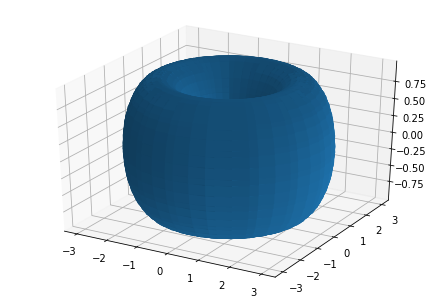

In [60]:
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
from numpy import (linspace, meshgrid, sin, cos)
from sympy.abc import u, t
%matplotlib inline

l = 10
N = 50
v = linspace(-l, l, N)
t, u = meshgrid(v, v)

x = (2 + cos(t))*cos(u)
y = (2 + cos(t))*sin(u)
z = sin(t)

fig = figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, z, rstride=1, cstride=1)


(b) Положить $a = cost, b = sint, c = cosu, d = sinu$ и переписать уравнения поверхности в переменных $a, b, c, d, x, y, z$.


$$x = 2 + ac,$$ $$y = 2 + ad,$$ $$z = b$$

(c) Пары переменных $a, b$ и $c, d$ **не** являются *независимыми*, так как выполняются полиномиальные тождества $$a^2 + b^2 - 1 = 0,$$ $$c^2 + d^2 - 1 = 0$$

Составим систему из пяти уравнений, присоединяя уравнения-тождества к уравнениям поверхности. Найдём базис Грёбнера соответствующего идеала, используя lex-упорядочение с $a>b>c>d>x>y>z$.



In [61]:
from sympy.abc import (a, b, c, d, x, y, z)

# a = cos(t)
# b = sin(t)
# c = cos(u)
# d = sin(u)

# x = 2 + a*c
# y = 2 + a*d
# z = b

I = [a*c - x + 2, a*d - y + 2, b - z, a**2 + b**2 - 1, c**2 + d**2 - 1]
print('I =', I)
G = groebner(I, a, b, c, d, x, y, z, order='lex')
print_groebner(G)
print('\n')


I = [a*c - x + 2, a*d - y + 2, b - z, a**2 + b**2 - 1, c**2 + d**2 - 1]
Базис Грёбнера:
 g1 = a - c*x + 2*c - d*y + 2*d
 g2 = b - z
 g3 = c**2 + d**2 - 1
 g4 = c*d*x - 2*c*d + d**2*y - 2*d**2 - y + 2
 g5 = c*d*z**2 - c*d + x*y - 2*x - 2*y + 4
 g6 = c*y - 2*c - d*x + 2*d
 g7 = d**2*z**2 - d**2 + y**2 - 4*y + 4
 g8 = x**2 - 4*x + y**2 - 4*y + z**2 + 7




В найденном базисе один полином $g_{8}$ зависит только от $x, y, z$. Он и задаёт многообразие, содержащее $T$.

### Упражнение 10 ###

Примените метод множителей Лагранжа и найдите точку $s$ на поверхности $x^4 + y^2 + z^2 - 1 = 0$, ближайшую к точке $(1, 1, 1)$ в $\mathbf{R}^3$.

**Решение**

Запишем задачу в стандартном виде. Нам нужно найти минимум функции $(x - 1)^2 + (y - 1)^2 + (z - 1)^2$ при условии $x^4 + y^2 + z^2 - 1 = 0$. $$\left\{ \begin{array}{ll}
 (x - 1)^2 + (y - 1)^2 + (z - 1)^2 \to min\\
 x^4 + y^2 + z^2 - 1 = 0
  \end{array} \right.$$
Составим функцию Лагранжа:
$$L(x, y, z, \lambda) = \lambda_{0}((x - 1)^2 + (y - 1)^2 + (z - 1)^2) + \lambda_{1}(x^4 + y^2 + z^2 - 1)$$ и вычислим частные производные:

In [62]:
from sympy.abc import m, l

L = m*((x - 1)**2 + (y - 1)**2 + (z - 1)**2) + l*(x**4 + y**2 + z**2 - 1)

L_x = diff(L, x)
L_y = diff(L, y)
L_z = diff(L, z)

print('L_x =', L_x, '\n')
print('L_y =', L_y, '\n')
print('L_z =', L_z, '\n')


L_x = 4*l*x**3 + m*(2*x - 2) 

L_y = 2*l*y + m*(2*y - 2) 

L_z = 2*l*z + m*(2*z - 2) 



$$\frac{ \partial L }{ \partial x }(x, y, z, \lambda) = \lambda_0(2x - 2) + 4\lambda_1x^3 ,$$
$$\frac{ \partial L }{ \partial y }(x, y, z, \lambda) = \lambda_0(2y - 2) + 2\lambda_1y ,$$
$$\frac{ \partial L }{ \partial z }(x, y, z, \lambda) = \lambda_0(2z - 2) + 2\lambda_1z$$

Образуем с их помощью систему:
$$\left\{ \begin{array}{ll}
 \lambda_0(2x - 2) + 4\lambda_1x^3 = 0\\
 \lambda_0(2y - 2) + 2\lambda_1y = 0\\
 \lambda_0(2z - 2) + 2\lambda_1z = 0\\
 x^4 + y^2 + z^2 - 1 = 0
  \end{array} \right.$$
  
Рассмотрим два случая:

а) Пусть $\lambda_0 = 0$. Но тогда система имеет решение лишь при $\lambda_0 = \lambda_1 = 0$, и экстремальных точек нет.


б) Пусть $\lambda_0 \not= 0$. Положим тогда $\lambda_0 = 1$:
$$\left\{ \begin{array}{ll}
 x - 1 + 2\lambda_1x^3 = 0\\
 y - 1 + \lambda_1y = 0\\
 z - 1 + \lambda_1z = 0\\
 x^4 + y^2 + z^2 - 1 = 0
  \end{array} \right.$$

Найдём решения с помощью базисов Грёбнера, используя lex-упорядочение $\lambda_1 > x > y > z$:

In [63]:
I = [2*l*x**3 + x - 1, l*y + y - 1, l*z + z - 1, x**4 + y**2 + z**2 - 1]
G = groebner(I, l, x, y, z, order='lex')
print('I =', I, '\n')
print_groebner(G)


I = [2*l*x**3 + x - 1, l*y + y - 1, l*z + z - 1, x**4 + y**2 + z**2 - 1] 

Базис Грёбнера:
 g1 = 8*l - 64*z**9 + 256*z**8 - 304*z**7 - 96*z**6 + 471*z**5 - 232*z**4 - 176*z**3 + 172*z**2 - 4*z - 24
 g2 = 4*x - 192*z**9 + 640*z**8 - 400*z**7 - 896*z**6 + 1285*z**5 + 54*z**4 - 840*z**3 + 252*z**2 + 156*z - 68
 g3 = y - z
 g4 = 64*z**10 - 256*z**9 + 304*z**8 + 96*z**7 - 471*z**6 + 232*z**5 + 176*z**4 - 172*z**3 + 4*z**2 + 32*z - 8


Мы используем уже испытанную выше технику и легко найдём список решений.


In [64]:
poly_system = G.exprs

G3, I2 = first_exclusion_step([z], poly_system, l, x, y)

print('\nБазис Грёбнера 3-ого исключающего идеала:')
print_groebner_of_ex(G3)


'''
roots_z = []
poly_system = []                            # Функция solve_poly_system из библиотеки SymPy не нашла правильные
for pol in G3:                              # корни из-за больших степеней в уравнении от z и погрешностей,
    f_z = Poly(pol[0], z)                   # поэтому я нашёл их другим методом
    poly_system.append(f_z)
roots_z = solve_poly_system(poly_system, z)
print('\nкорни Z:', roots_z)
'''

roots_z = [(0.6348187101019142,), (-0.623520405481625,)]
print('\nкорни Z:', roots_z)


poly_system = []
for pol in I2:
    poly_system.append(pol[0].subs(z, roots_z[0][0]))
    
G2, I1 = exclusion_step([y], poly_system, I2, l, x)

print('\nБазис Грёбнера 2-ого исключающего идеала:')
print_groebner_of_ex(G2)


roots_y = []
for root_z in roots_z:
    poly_system = []
    for pol in G2:
        f_y = Poly(pol[0].as_expr().subs(z, root_z[0]), y)
        poly_system.append(f_y)
    solution = solve_poly_system(poly_system, y)
    roots_y.append(solution)
print('\nкорни Y:', roots_y)


poly_system = []
for pol in I1:
    poly_system.append(pol[0].subs({y:roots_y[0][0], z:roots_z[0][0]}))

G1, I0 = exclusion_step([x], poly_system, I1, l)

print('\nБазис Грёбнера 1-ого исключающего идеала:')
print_groebner_of_ex(G1)


roots_x = []
for i in range(len(roots_z)):
    for root_y in roots_y[i]:
        poly_system = []
        for pol in G1:
            poly_system.append(Poly(pol[0].as_expr().subs({y:root_y, z:roots_z[i][0]}), l, x))
        solution = solve_poly_system(poly_system, x)
        roots_x.append(solution)
print('\nКорни X:', roots_x)


roots_l = []
for i in range(len(roots_z)):
    for j in range(len(roots_y[i])):
        poly_system = []
        for pol in I0:
            poly_system.append(Poly(pol[0].as_expr().subs({x:roots_x[i][j][0], y:roots_y[i][j][0], z:roots_z[i][0]}), l))
        solution = solve_poly_system(poly_system, l)
        roots_l.append(solution)
print('\nКорни lambda:', roots_l)


solutions = []
index = 0
for i in range(len(roots_z)):
    for j in range(len(roots_y[i])):
        solutions.append((roots_l[index][0][0], roots_x[index][0][0], roots_y[i][j][0], roots_z[i][0]))
        index += 1
print('\nВсе решения системы: ')
print(*solutions, sep='\n')



Базис Грёбнера 3-ого исключающего идеала:
 g4 = 64*z**10 - 256*z**9 + 304*z**8 + 96*z**7 - 471*z**6 + 232*z**5 + 176*z**4 - 172*z**3 + 4*z**2 + 32*z - 8

корни Z: [(0.6348187101019142,), (-0.623520405481625,)]

Базис Грёбнера 2-ого исключающего идеала:
 g3 = y - z

корни Y: [[(0.634818710101914,)], [(-0.623520405481625,)]]

Базис Грёбнера 1-ого исключающего идеала:
 g2 = 4*x - 192*z**9 + 640*z**8 - 400*z**7 - 896*z**6 + 1285*z**5 + 54*z**4 - 840*z**3 + 252*z**2 + 156*z - 68

Корни X: [[(0.663676222858363,)], [(-0.686760757676232,)]]

Корни lambda: [[(0.575252877848319,)], [(-2.60379675027016,)]]

Все решения системы: 
(0.575252877848319, 0.663676222858363, 0.634818710101914, 0.6348187101019142)
(-2.60379675027016, -0.686760757676232, -0.623520405481625, -0.623520405481625)



Итак, мы получили две подозрительные на экстремум точки. Определим, какая из них является минимумом. Для этого найдём дифференциал второго порядка.


In [65]:
L = ((x - 1)**2 + (y - 1)**2 + (z - 1)**2) + l*(x**4 + y**2 + z**2 - 1)

L_xx = diff(L, x, x)
L_yy = diff(L, y, y)
L_zz = diff(L, z, z)
L_xy = diff(L, x, y)
L_xz = diff(L, x, z)
L_yz = diff(L, y, z)

print('L_xx =', L_xx, '\n')
print('L_yy =', L_yy, '\n')
print('L_zz =', L_zz, '\n')
print('L_xy =', L_xy, '\n')
print('L_xz =', L_xz, '\n')
print('L_yz =', L_yz, '\n')


L_xx = 2*(6*l*x**2 + 1) 

L_yy = 2*(l + 1) 

L_zz = 2*(l + 1) 

L_xy = 0 

L_xz = 0 

L_yz = 0 



$$d^2L = L''_{xx}(dx)^2 + L''_{yy}(dy)^2 + L''_{zz}(dz)^2 + 2L''_{xy}(dxdy) + 2L''_{xz}(dxdz) + 2L''_{yz}(dydz)$$
$$d^2L = (12\lambda x^2 + 2)(dx)^2 + (2\lambda + 2)(dy)^2 + (2\lambda + 2)(dz)^2$$

Подставим найденные точки в выражение

In [66]:
a1 = L_xx.subs({l:solutions[0][0], x:solutions[0][1], y:solutions[0][2], z:solutions[0][3]})
b1 = L_yy.subs({l:solutions[0][0], x:solutions[0][1], y:solutions[0][2], z:solutions[0][3]})
c1 = L_zz.subs({l:solutions[0][0], x:solutions[0][1], y:solutions[0][2], z:solutions[0][3]})

a2 = L_xx.subs({l:solutions[1][0], x:solutions[1][1], y:solutions[1][2], z:solutions[1][3]})
b2 = L_yy.subs({l:solutions[1][0], x:solutions[1][1], y:solutions[1][2], z:solutions[1][3]})
c2 = L_zz.subs({l:solutions[1][0], x:solutions[1][1], y:solutions[1][2], z:solutions[1][3]})

print('d^2L = ', a1, '(dx)^2 + ', b1, '(dy)^2 + ', c1, '(dz)^2\n', sep='')
print('d^2L = ', a2, '(dx)^2 + ', b2, '(dy)^2 + ', c2, '(dz)^2\n', sep='')


d^2L = 5.04055289815692(dx)^2 + 3.15050575569664(dy)^2 + 3.15050575569664(dz)^2

d^2L = -12.7366669614434(dx)^2 + -3.20759350054033(dy)^2 + -3.20759350054033(dz)^2



Итак, мы получили:
$$d^2L = 5(dx)^2 + 3,15(dy)^2 + 3,15(dz)^2 > 0,$$ значит, мы получили локальный минимум, то есть нашли точку $s = (0,664; 0,635; 0,635)$ на поверхности $x^4 + y^2 + z^2 - 1 = 0$, ближайшую к точке $(1, 1, 1)$ в $\mathbf{R}^3$.

При этом мы так же получили локальный максимум, так как в точке $(-0,687; -0,623; -0,623)$:
$$d^2L = -12,7(dx)^2 - 3,2(dy)^2 - 3,2(dz)^2 < 0$$


### Упражнение 11 ###

$$a + b + c - 3 = 0,$$
$$a^2 + b^2 + c^2 - 5 = 0,$$
$$a^3 + b^3 + c^3 - 7 = 0$$

(a) Доказать, что $a^4 + b^4 + c^4 - 9 = 0$. Иными словами, доказать, что $a^4 + b^4 + c^4 - 9 \in (a + b + c - 3, a^2 + b^2 + c^2 - 5, a^3 + b^3 + c^3 - 7)$

**Решение**

In [68]:
from sympy.abc import a, b, c

I = [a + b + c - 3, a**2 + b**2 + c**2 - 5, a**3 + b**3 + c**3 - 7]
f = a**4 + b**4 + c**4 - 9

print('I = ', I)
print('f = ', f, '\n')

def in_ideal(f, I, a, b, c):
    G = groebner(I, a, b, c, order='lex')
    print_groebner(G)
    if G.contains(f):                                   # метод contains() проверяет, принадлежит ли полином идеалу
        print('\nf принадлежит идеалу I \n')
    else:
        print('\nf не принадлежит идеалу I \n')
        
in_ideal(f, I, a, b, c)


I =  [a + b + c - 3, a**2 + b**2 + c**2 - 5, a**3 + b**3 + c**3 - 7]
f =  a**4 + b**4 + c**4 - 9 

Базис Грёбнера:
 g1 = a + b + c - 3
 g2 = b**2 + b*c - 3*b + c**2 - 3*c + 2
 g3 = 3*c**3 - 9*c**2 + 6*c + 2

f принадлежит идеалу I 



(b) Докажите, что $a^5 + b^5 + c^5 \not= 11$

In [69]:
f = a**5 + b**5 + c**5 - 11

in_ideal(f, I, a, b, c)


Базис Грёбнера:
 g1 = a + b + c - 3
 g2 = b**2 + b*c - 3*b + c**2 - 3*c + 2
 g3 = 3*c**3 - 9*c**2 + 6*c + 2

f не принадлежит идеалу I 



$a^5 + b^5 + c^5 - 11 \not\in (a + b + c - 3, a^2 + b^2 + c^2 - 5, a^3 + b^3 + c^3 - 7)$, следовательно, $a^5 + b^5 + c^5 \not=11$
